In [1]:
import json
import logging
import sys
import types
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from qamts.simulator import QAMTSimulator
from qamts.scheduler import StaticScheduler, NextFitTaskPreemption, NaiveScheduler
from qamts.annealer import Chimera
from qamts.instruction import QMI
from qamts.task import Task
from qamts.visualisation import plotTime, plotAlloc
from qamts.utils import randomTasks
from qamts.metrics import TaskTiming, calcResourceUtilisation, SchedulerSpeedometer

# Task generation

In [2]:
tasks_json = randomTasks(100, anneal_time=100, seed=0)

# Simulation

## Logging

Logging is enabled in QAMTS simulator. ``sim_time`` is used to print the simulation time.

In [3]:
def logger_factory(name):
#     fmt = '%(asctime)s | %(name)s | %(levelname)-8s | %(message)s'
    fmt = '%(sim_time)s | %(message)s'
    formatter = logging.Formatter(fmt=fmt)
    screen_handler = logging.StreamHandler(stream=sys.stdout)
    screen_handler.setFormatter(formatter)
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    logger.handlers.clear()
    logger.addHandler(screen_handler)
    return logger

# Uncomment the following line to enable logging
# logger_factory('')

## Define the simulation

In [4]:
# Load the tasks from json data
tasks = Task.load(tasks_json)

# Construct an array of unit cells
annealer = Chimera((16, 16))

# Instantiate a scheduler
scheduler = NextFitTaskPreemption()

# Add a timer to measure the timing of scheduling algorithm
meter = SchedulerSpeedometer()
scheduler.schedule = meter.decorate(scheduler.schedule)

# Create the simulator
sim = QAMTSimulator(
    tasks,
    annealer,
    scheduler,
    static_scheduling=True,
)

## Run it

In [5]:
sim.run()

# Inspection

## Check the timing of the tasks

In [6]:
tt = TaskTiming(tasks)
print('Average-case Execution Time (ACET)',  tt.ACET())
print('Worst-case Execution Time (WCET)',  tt.WCET())
print('Average-case Response Time (ACRT)',  tt.ACRT())
print('Worst-case Response Time (WCRT)',  tt.WCRT())
print('Average-case Initial Wait Time (ACIWT)', tt.ACIWT())
print('Worst-case Initial Wait (WCIWT)', tt.WCIWT())

Average-case Execution Time (ACET) 162700.0
Worst-case Execution Time (WCET) 1090000
Average-case Response Time (ACRT) 913320.0
Worst-case Response Time (WCRT) 2714000
Average-case Initial Wait Time (ACIWT) 750620.0
Worst-case Initial Wait (WCIWT) 2672000


## Resource Utilisation

Get the Quantum Machine Instrcution (QMI) and calculate the resource utilisation

In [7]:
insts = sim.getInstructionComplete()
restuil = calcResourceUtilisation(insts)
print('Resource utilisation in percentage (%)', restuil)

Resource utilisation in percentage (%) 0.47446400607958733


## Timing of the scheduler

The following figure shows relation between the number of input tasks and the time for producing a schedule

Text(0, 0.5, 'Time')

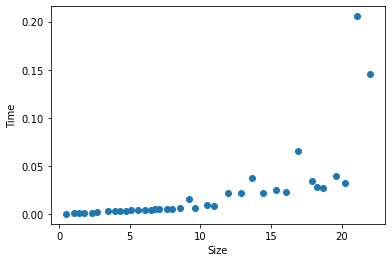

In [8]:
stats = meter.getStats()
stats_tasks = [t for t, t_sizes, period in stats]
stats_size = [sum(t_sizes) for t, t_sizes, period in stats]
stats_period = [period for t, t_sizes, period in stats]
fig, ax = plt.subplots()
ax.scatter(stats_size, stats_period)
ax.set_xlabel('Size')
ax.set_ylabel('Time')

## Task timing v.s. Resource utilisation

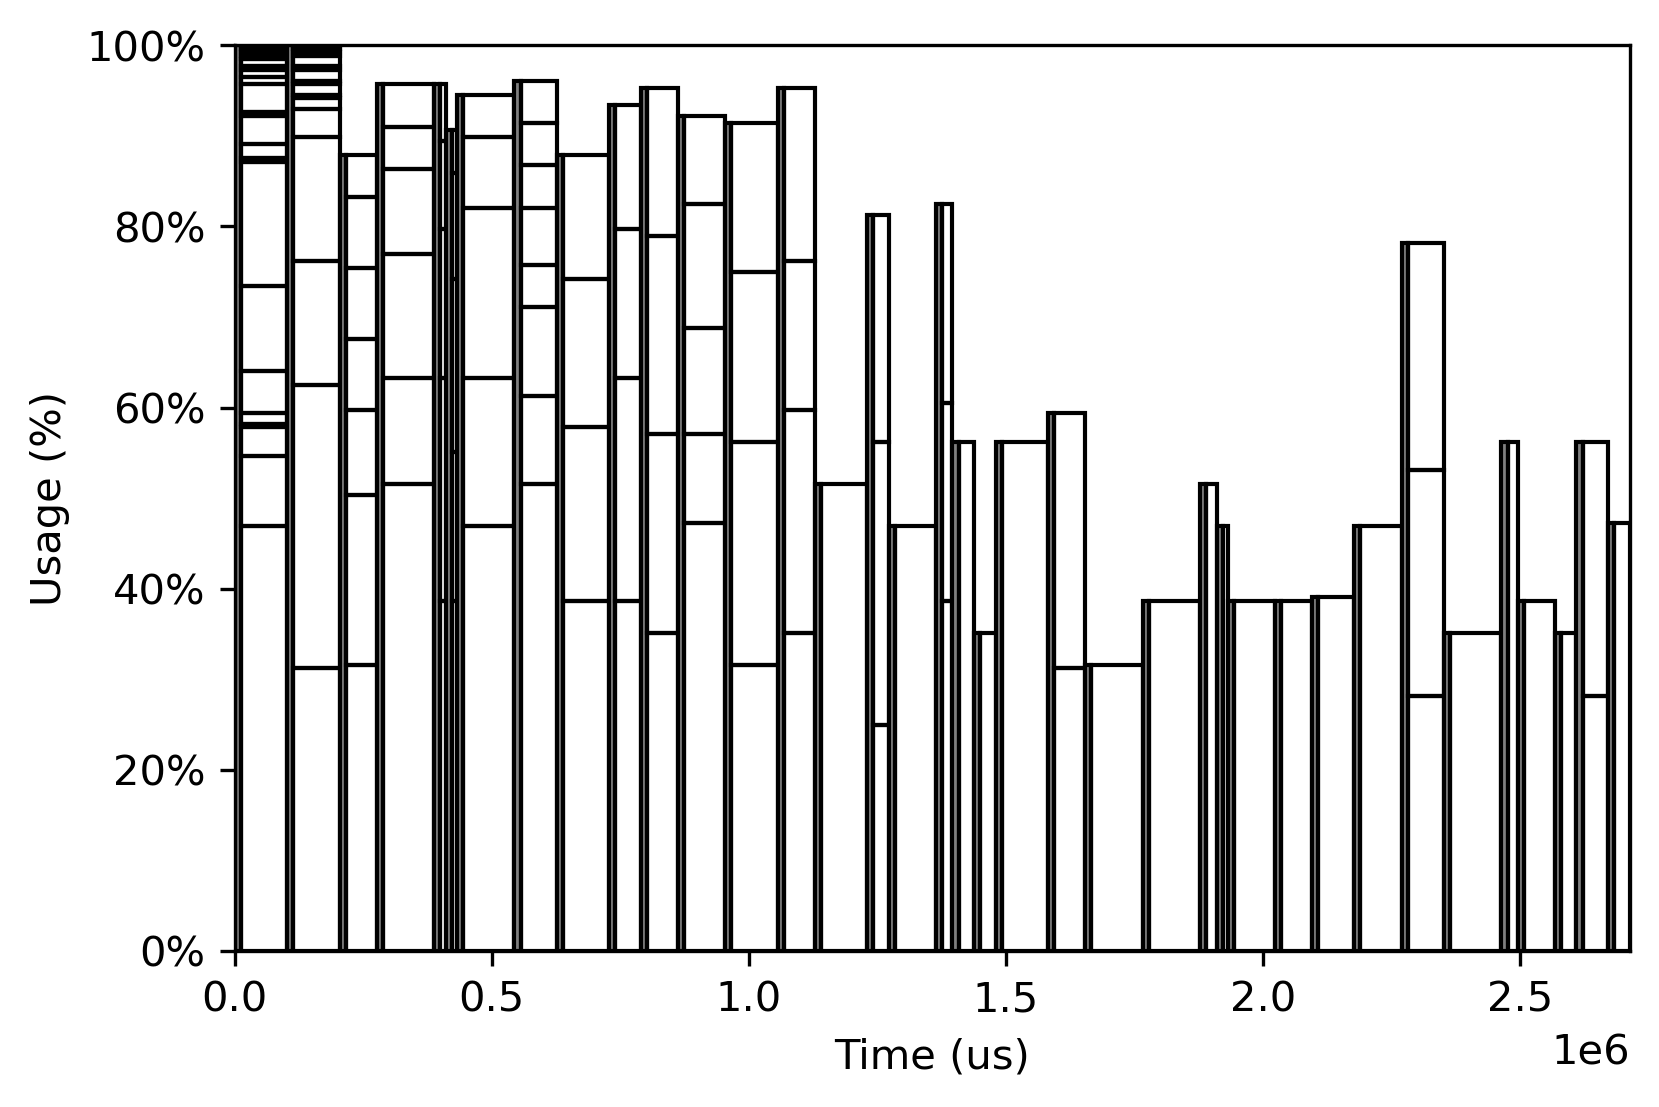

In [9]:
fig, ax = plt.subplots(dpi=300)
# fig, ax = plt.subplots()
ax.set_xlabel('Time (us)')
ax.set_ylabel('Usage (%)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

for inst in insts:
    plotTime(inst, ax=ax)

## Per QMI Resource Allocation

The following figures illustrate the resouce allocation of the first 3 QMIs

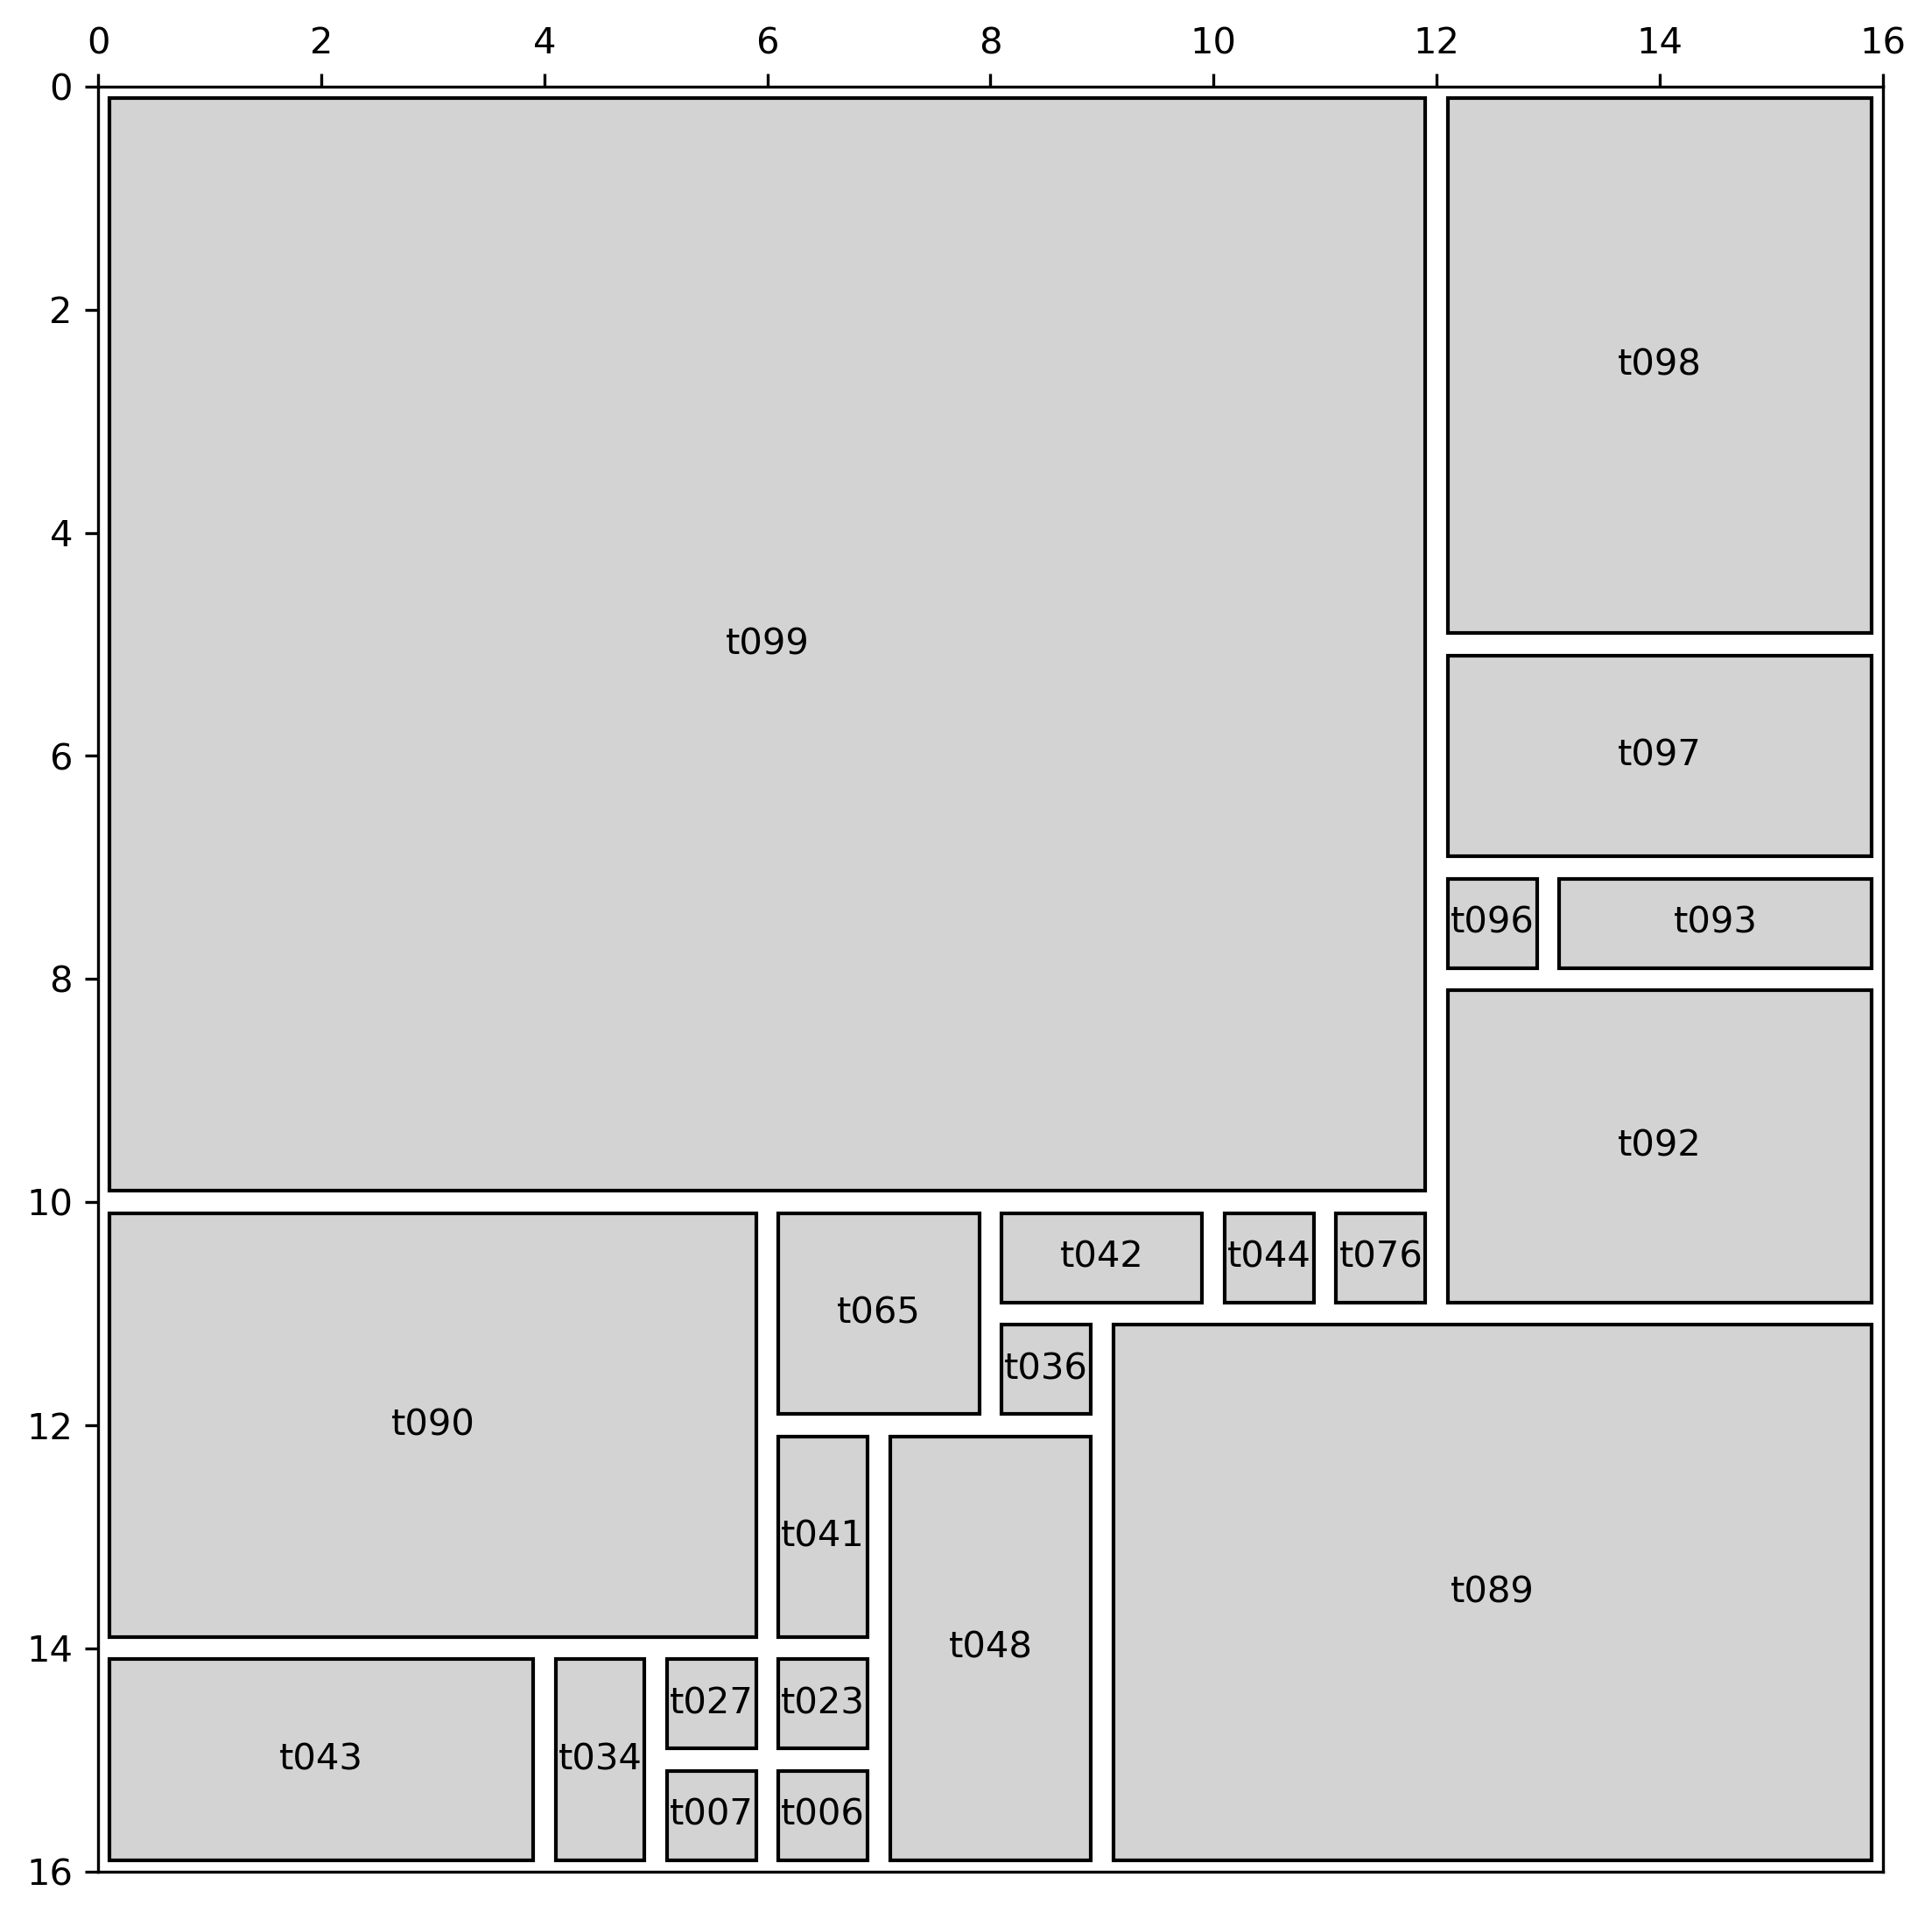

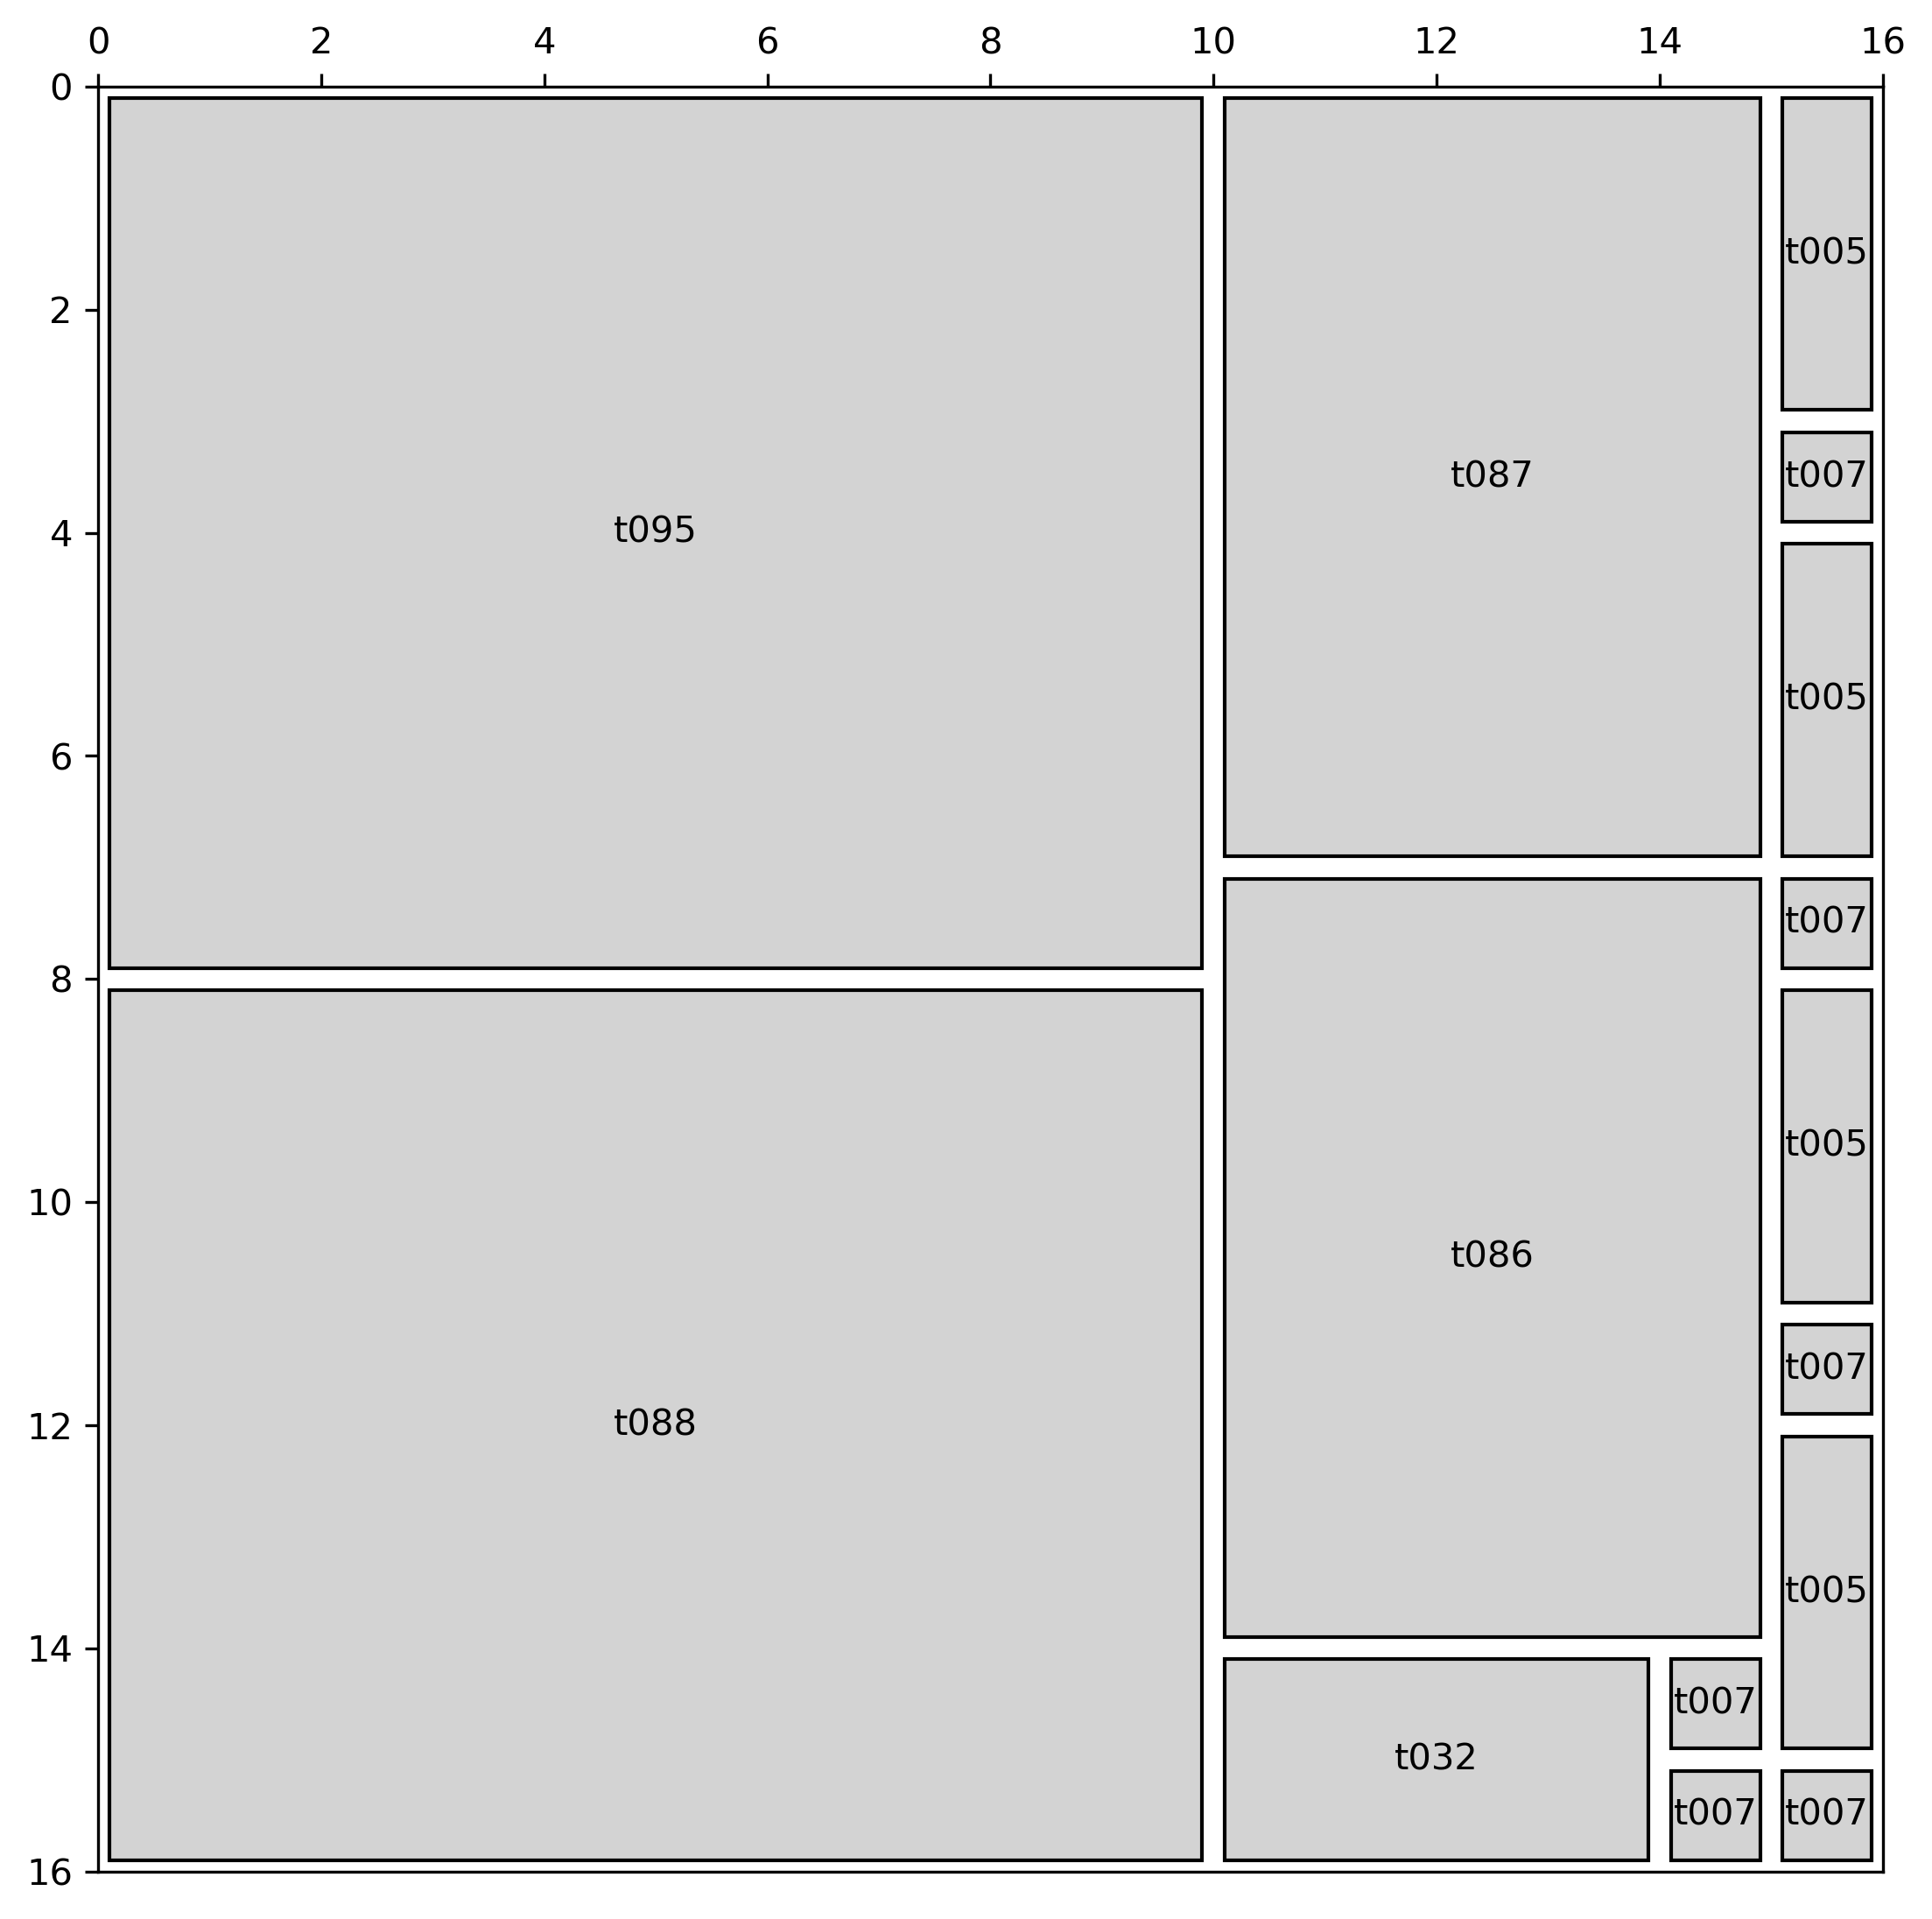

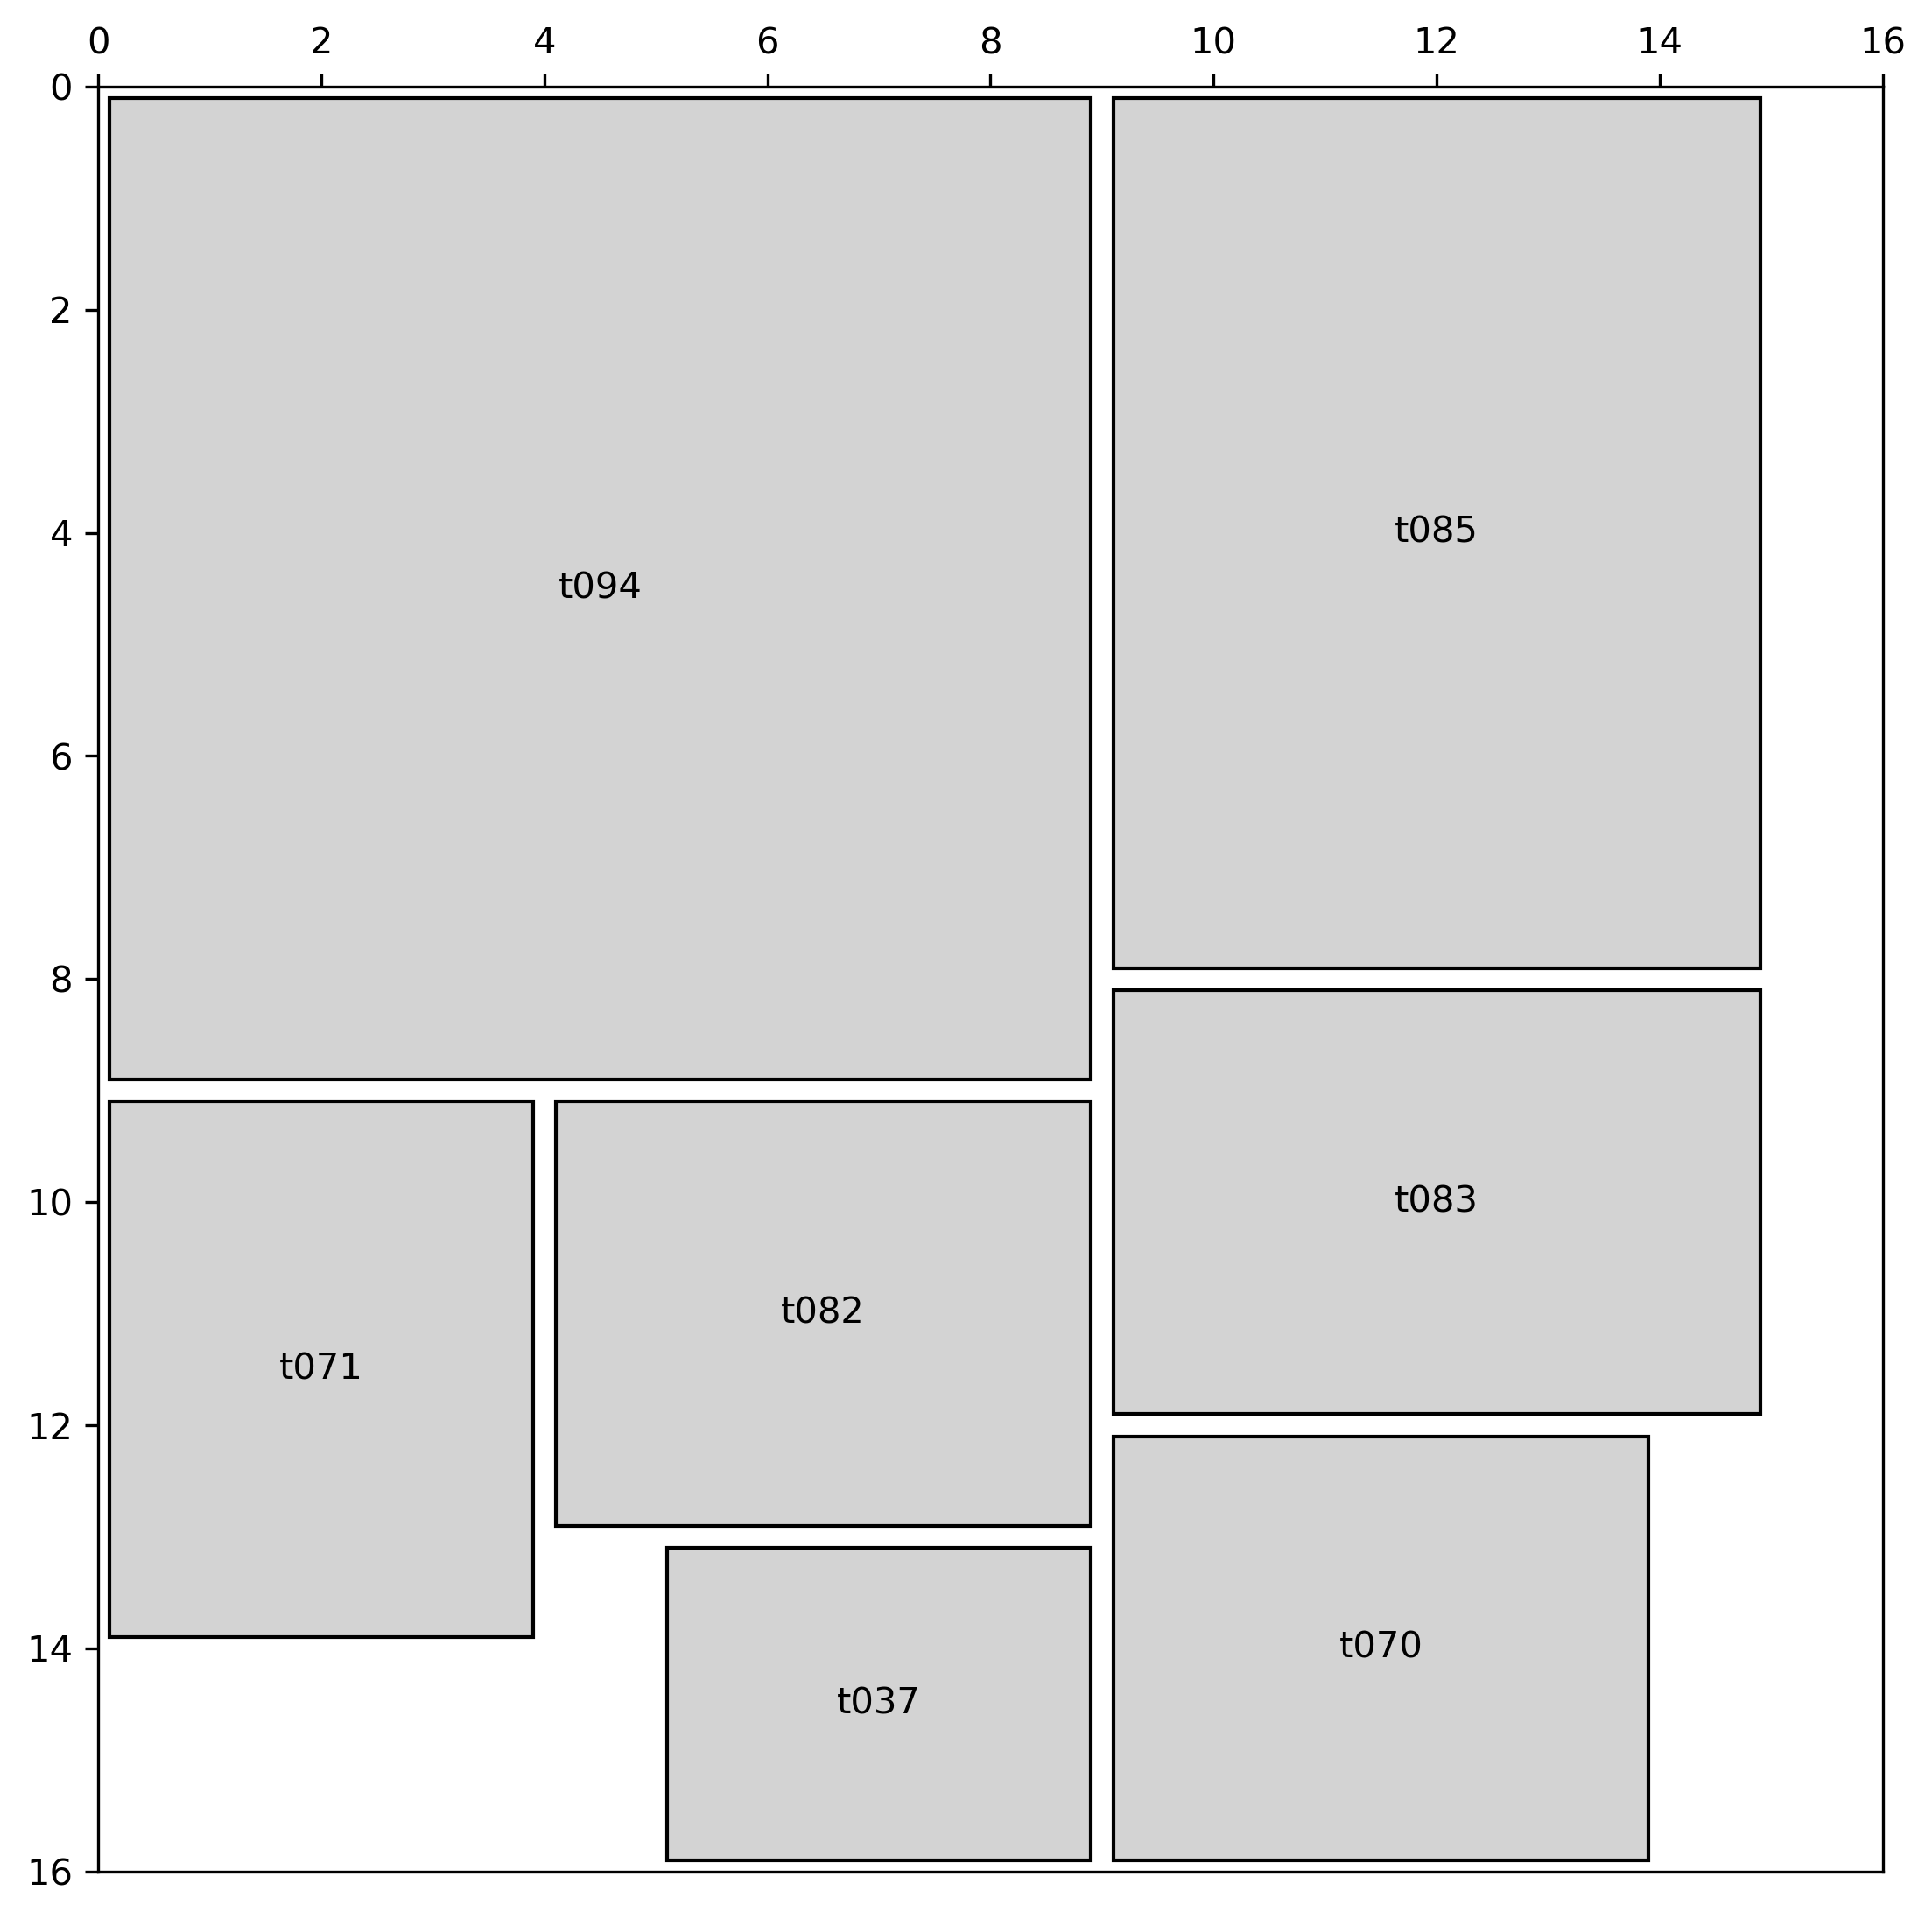

In [10]:
for inst in insts[:3]:
    alloc = inst.getAllocs()[0]

    fig, ax = plt.subplots(figsize=(9,9), dpi=300)
    H, W = alloc.shape
    ax.set_xlim([0, W])
    ax.set_ylim([0, H])
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    ax.xaxis.tick_top()

    for alloc, t in zip(inst.getAllocs(), inst.getTasks()):
        ax = plotAlloc(alloc, label=t.name, ax=ax)


## Seeded task generation

Use ten random seed to generate task sets and simulate.

In [11]:
def test_machine(seed, static_scheduling=True):
    tasks_json = randomTasks(100, anneal_time=100, seed=seed)
    
    tasks = Task.load(tasks_json)
    annealer = Chimera((16, 16))
    scheduler = NextFitTaskPreemption()
#     scheduler = NaiveScheduler()
    meter = SchedulerSpeedometer()
    scheduler.schedule = meter.decorate(scheduler.schedule)

    sim = QAMTSimulator(
        tasks,
        annealer,
        scheduler,
        static_scheduling=static_scheduling,
    )

    sim.run()

    # Task timing
    tt = TaskTiming(tasks)
    res = annealer.getRes().size
    tt_sizes = [t.getEmbd().sum() / res for t, t_arrive, t_start, t_complete in tt.getTiming()]
    tt_wait =  [(t_start-t_arrive) / t.getAnnealTime() / t.getNumSamples() for t, t_arrive, t_start, t_complete in tt.getTiming()]
    tt_resp =  [(t_complete-t_arrive)  / t.getAnnealTime() / t.getNumSamples() for t, t_arrive, t_start, t_complete in tt.getTiming()]
    tt_et =    [(t_complete-t_start) / t.getAnnealTime() / t.getNumSamples() for t, t_arrive, t_start, t_complete in tt.getTiming()]
    
    # Scheduler speed
    stats = meter.getStats()
    speed_size = [sum(t_sizes) for t, t_sizes, period in stats]
    speed_period = [period for t, t_sizes, period in stats]
    
    # Resource utilisation
    
    insts = sim.getInstructionComplete()
    restuil = calcResourceUtilisation(insts)
    
    timespan = max(inst.getTiming()[1] for inst in insts)

    data = {
        'tt_sizes': tt_sizes,
        'tt_wait': tt_wait,
        'tt_resp': tt_resp,
        'tt_et': tt_et,
        'speed_size': speed_size,
        'speed_period': speed_period,
        'ru': restuil,
        'timespan':timespan,
    }
    
    return data

In [12]:
tt_sizes = []
tt_wait = []
tt_resp = []
tt_et = []
speed_size = []
speed_period = []
restuil = []
timespan = []

for i in range(10):
    data = test_machine(i)
    tt_sizes.extend(data['tt_sizes'])
    tt_wait.extend(data['tt_wait'])
    tt_resp.extend(data['tt_resp'])
    tt_et.extend(data['tt_et'])
    speed_size.extend(data['speed_size'])
    speed_period.extend(data['speed_period'])
    restuil.append(data['ru'])
    timespan.append(data['timespan'])

### Task timing v.s. resource requirement

Resource requirement is the number of unit cells required by a task, i.e., size of embedding.

/home/huangtian/miniconda3/envs/warehouse/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/huangtian/miniconda3/envs/warehouse/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/huangtian/miniconda3/envs/warehouse/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/huangtian/miniconda3/envs/warehouse/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/huangtian/miniconda3/envs/warehouse/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


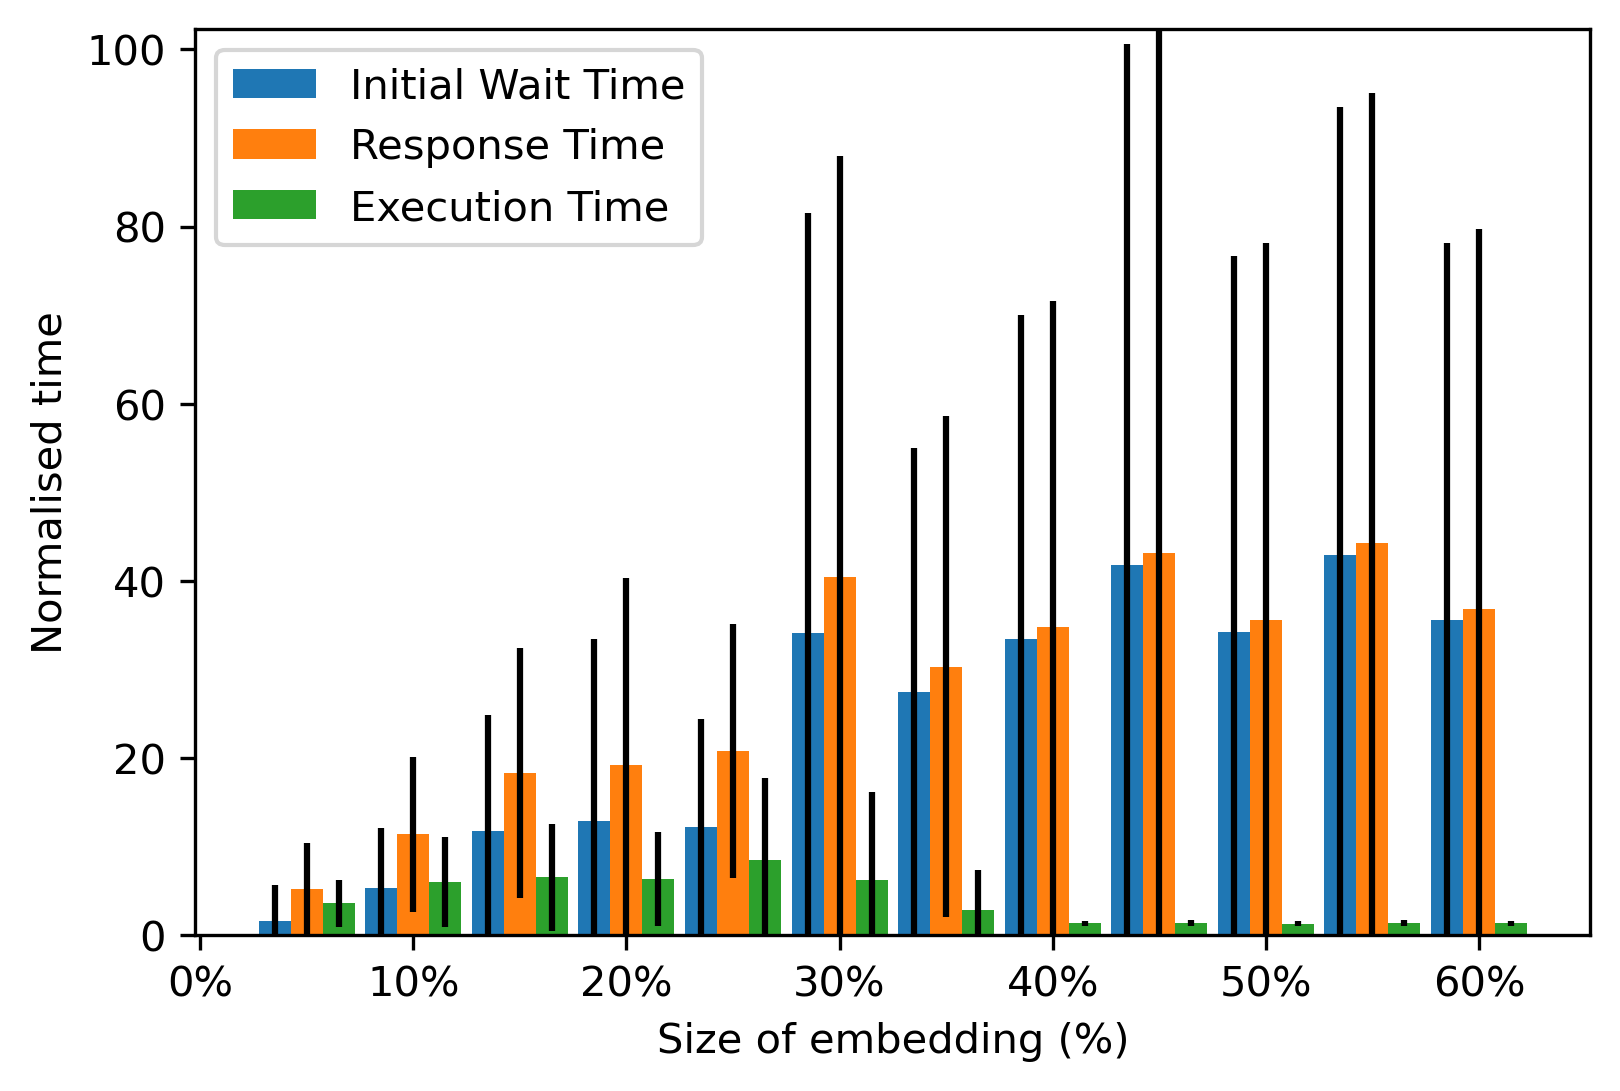

In [13]:
bins = np.arange(0.0, 1.0, 0.05)
tt_sizes_id = np.digitize(tt_sizes, bins, right=False)
xdata = bins
ydata_wait = [[] for i in xdata]
ydata_resp = [[] for i in xdata]
ydata_et   = [[] for i in xdata]
for i, _id in enumerate(tt_sizes_id):
    ydata_wait[_id].append(tt_wait[i])
    ydata_resp[_id].append(tt_resp[i])
    ydata_et[_id].append(tt_et[i])
ydata_wait_mean = np.asarray([np.mean(d) for d in ydata_wait])
ydata_resp_mean = np.asarray([np.mean(d) for d in ydata_resp])
ydata_et_mean   = np.asarray([np.mean(d) for d in ydata_et])
ydata_wait_std = np.asarray([np.std(d) for d in ydata_wait])
ydata_resp_std = np.asarray([np.std(d) for d in ydata_resp])
ydata_et_std   = np.asarray([np.std(d) for d in ydata_et])

barWidth = 0.015
offsets = [-barWidth, 0, barWidth]
ymax = max(np.nanmax(ydata_wait_mean + ydata_wait_std), 
           np.nanmax(ydata_resp_mean + ydata_resp_std), 
           np.nanmax(ydata_et_mean + ydata_et_std))

labels = ['Initial Wait Time', 'Response Time', 'Execution Time']

fig, ax = plt.subplots(dpi=300)

for mean, std, offset, label in zip([ydata_wait_mean, ydata_resp_mean, ydata_et_mean], 
                                     [ydata_wait_std, ydata_resp_std, ydata_et_std], 
                                     offsets, labels):
    ax.bar(xdata+offset, mean, barWidth, yerr=std, label=label)

ax.set_ylim([0, ymax])
ax.set_ylabel('Normalised time')
ax.set_xlabel('Size of embedding (%)')
ax.legend(loc='upper left')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))


In [14]:
print('Resource Utilisation', np.mean(restuil), np.std(restuil))

Resource Utilisation 0.49699415152208737 0.02434480169876935


In [15]:
print('Time span', np.mean(timespan), np.std(timespan))

Time span 2510000.0 367902.1609069455


### Scheduler timing v.s. resource requirement

Text(0.5, 0, 'Total size of embedding')

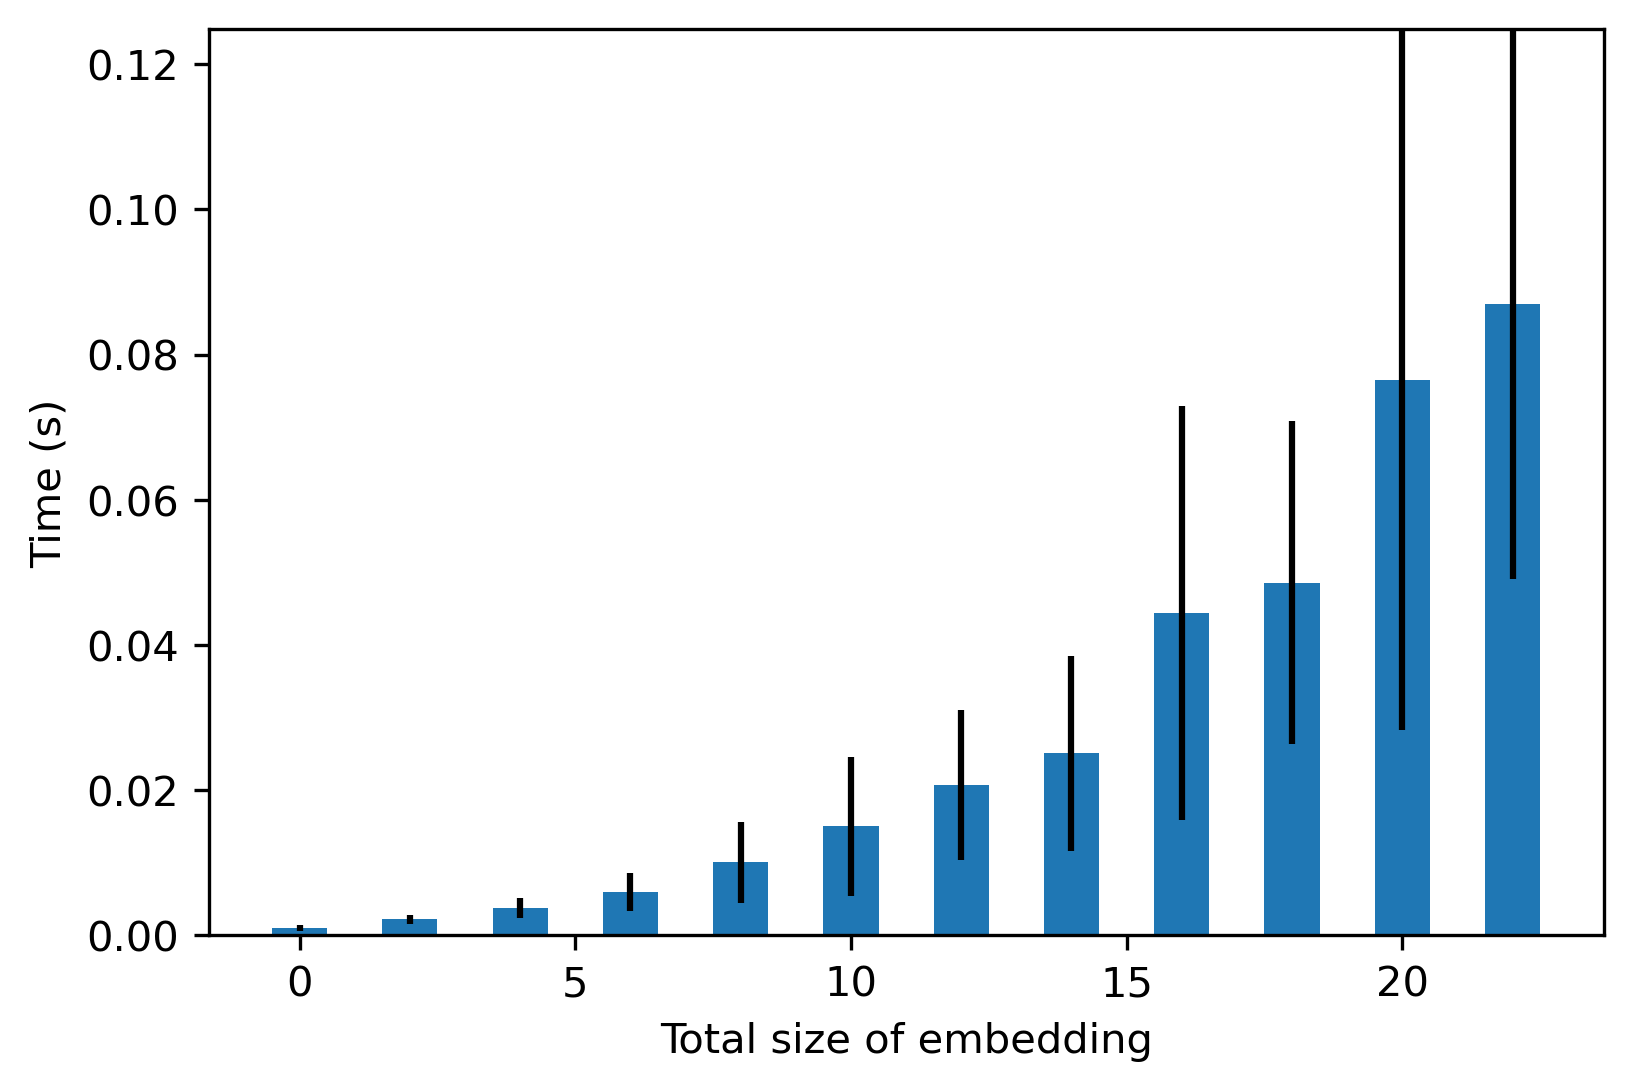

In [16]:
bins = np.arange(0.0, 23, 2.0)
speed_size_id = np.digitize(speed_size, bins, right=False)
xdata = bins
ydata = [[] for i in xdata]
for i, _id in enumerate(speed_size_id):
    ydata[_id-1].append(speed_period[i])
ydata_mean = np.asarray([np.mean(d) for d in ydata])
ydata_std  = np.asarray([np.std(d)  for d in ydata])

barWidth = 1
ymax = np.nanmax(ydata_mean + ydata_std)

fig, ax = plt.subplots(dpi=300)
ax.bar(xdata, ydata_mean, barWidth, yerr=ydata_std)
ax.set_ylim([0, ymax])
ax.set_ylabel('Time (s)')
ax.set_xlabel('Total size of embedding')
